In [1]:
from keras import layers
import tensorflow as tf
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)


df = pd.read_csv('../csv_dateien/starcraftFinalcsvs/allRunsButOnlyTerran.csv')

conditions = [
    (df['fraction'] == "Protoss"), #1
    (df['fraction'] == "Terraner"), #2
    (df['fraction'] == "Zerg"), #3
    (df['fraction'] == "T"), #2
]

values = [1, 2, 3, 2]

df["fraction"] = np.select(conditions, values)
df=df[df["total_army"]>0]
df=df[df["fraction"]==2]
df=df[df["supply"]<=200]

dfPrepSample = df.drop(columns=["player","winner","replay_filename", "Unnamed: 0", "total_army_value","fraction"])
len(dfPrepSample)


3009

In [2]:
# optimizer with scaling and lin reg

import warnings
import gurobipy as gp
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr



# ,player,total_workers,total_army_value,total_army,fraction,winner,replay_filename
dfOpt = dfPrepSample.drop(columns=[
                               "total_workers"])

dfOpt


,resource_mining,total_army,supply,time
1,28154,96.0,174.0,836
6,40998,120.0,196.0,934
15,13965,45.0,117.0,583
19,9595,26.0,62.0,449
24,38030,98.0,165.0,1102
...,...,...,...,...
5888,7364,17.0,69.0,381
5889,25845,80.0,173.0,878
5893,26351,70.0,157.0,795
5894,24263,76.0,165.0,754


In [4]:


# create variables
# create Model

m = gp.Model("Balance optimizer")
gppd.set_interactive()

w = gppd.add_vars(m, pandas_obj=dfOpt,
                  name="total_workers", vtype=gp.GRB.INTEGER)

s = gppd.add_vars(m, pandas_obj=dfOpt,
                  name="supply")

a = gppd.add_vars(m, pandas_obj=dfOpt,
                  name="total_army")

m.update()
dfOpt = dfOpt.drop(columns=["total_army"])

feats = dfOpt
feats = pd.concat([w, feats], axis=1)
feats.head


Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-17


<bound method NDFrame.head of                          total_workers  resource_mining  supply  time
1        <gurobi.Var total_workers[1]>            28154   174.0   836
6        <gurobi.Var total_workers[6]>            40998   196.0   934
15      <gurobi.Var total_workers[15]>            13965   117.0   583
19      <gurobi.Var total_workers[19]>             9595    62.0   449
24      <gurobi.Var total_workers[24]>            38030   165.0  1102
...                                ...              ...     ...   ...
5888  <gurobi.Var total_workers[5888]>             7364    69.0   381
5889  <gurobi.Var total_workers[5889]>            25845   173.0   878
5893  <gurobi.Var total_workers[5893]>            26351   157.0   795
5894  <gurobi.Var total_workers[5894]>            24263   165.0   754
5895  <gurobi.Var total_workers[5895]>            22655   125.0   726

[3009 rows x 4 columns]>

In [5]:
sc_model = tf.keras.models.load_model('sc_ts_model.h5')


In [6]:


m.setObjective(a.sum(), gp.GRB.MAXIMIZE) # Zielfunktion
"""
gppd.add_constrs(m, ((av - 50*w)/100), gp.GRB.GREATER_EQUAL, a) # Gleichung 2
"""
gppd.add_constrs(m, w + a, gp.GRB.GREATER_EQUAL, 0) # Gleichung 3
gppd.add_constrs(m, w + a, gp.GRB.LESS_EQUAL, s) # Gleichung 4
m.update()

pred_constr = add_predictor_constr(m, sc_model, feats, a) # Einfügen des Regressiosmodells
pred_constr.print_stats()
m.Params.NonConvex = 2
m.optimize()


Model for sequential1:
99297 variables
33099 constraints
60180 general constraints
Input has shape (3009, 4)
Output has shape (3009, 1)

--------------------------------------------------------------------------------
Layer           Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
dense0             (3009, 5)        30090        15045            0        15045 (relu)

relu1              (3009, 5)        15045            0            0        15045

dense2             (3009, 5)        30090        15045            0        15045 (relu)

relu3              (3009, 5)        15045            0            0        15045

dense4             (3009, 1)            0         3009            0            0

--------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen In

In [7]:


outputs = pred_constr.input_values
pred_constr.input_values



,total_workers,resource_mining,supply,time
1,-0.0,28154.0,174.0,836.0
6,-0.0,40998.0,196.0,934.0
15,-0.0,13965.0,117.0,583.0
19,-0.0,9595.0,62.0,449.0
24,-0.0,38030.0,165.0,1102.0
...,...,...,...,...
5888,-0.0,7364.0,69.0,381.0
5889,-0.0,25845.0,173.0,878.0
5893,-0.0,26351.0,157.0,795.0
5894,-0.0,24263.0,165.0,754.0


In [8]:

solution = pd.DataFrame()

solution["supply"] = s.gppd.X
solution["army"] = a.gppd.X
pred_constr.input_values["total_workers"] = w
solution


,supply,army,worker
1,130.384879,130.384879,<gurobi.Var total_workers[1] (value -0.0)>
6,151.341541,151.341541,<gurobi.Var total_workers[6] (value -0.0)>
15,69.243749,69.243749,<gurobi.Var total_workers[15] (value -0.0)>
19,40.575067,40.575067,<gurobi.Var total_workers[19] (value -0.0)>
24,133.218982,133.218982,<gurobi.Var total_workers[24] (value -0.0)>
...,...,...,...
5888,28.160835,28.160835,<gurobi.Var total_workers[5888] (value -0.0)>
5889,129.651630,129.651630,<gurobi.Var total_workers[5889] (value -0.0)>
5893,117.766166,117.766166,<gurobi.Var total_workers[5893] (value -0.0)>
5894,121.473006,121.473006,<gurobi.Var total_workers[5894] (value -0.0)>


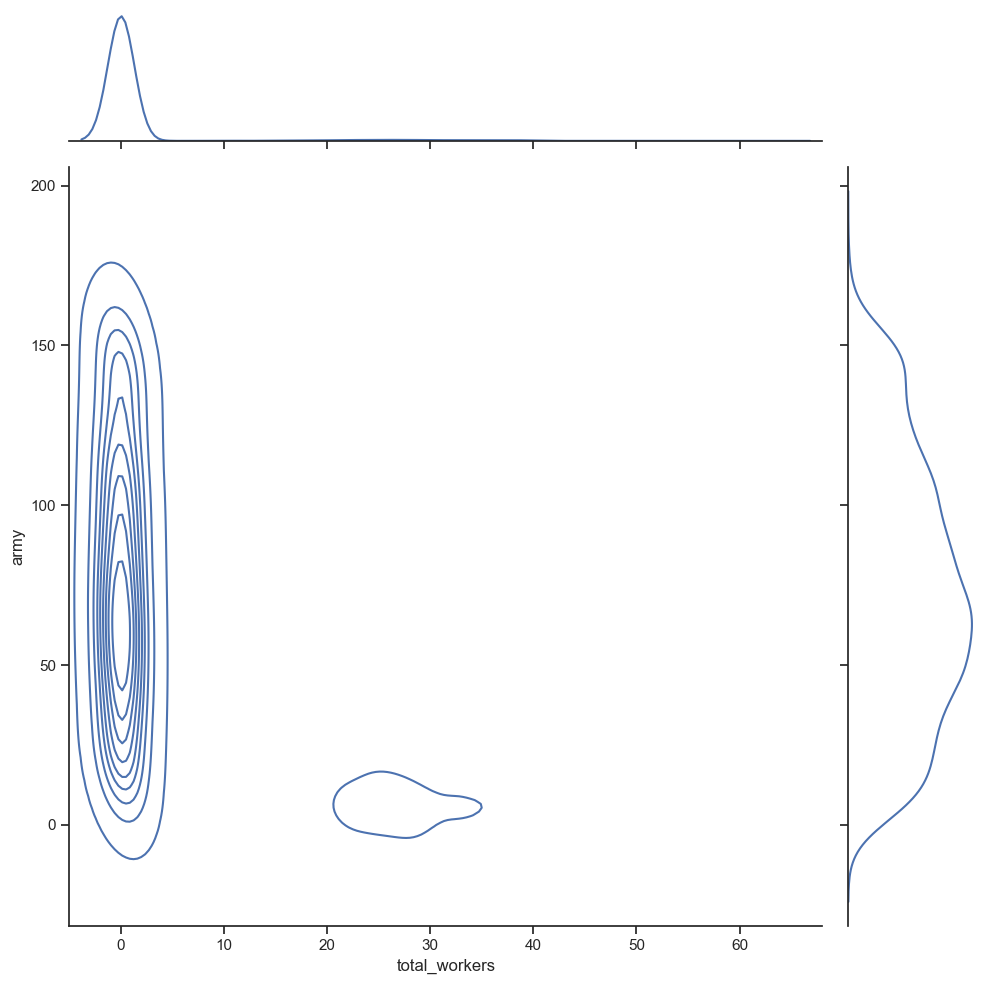

In [11]:

custom_palette = ["#dd8452","#4c72b0",  "#55a868"]
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=solution, palette=custom_palette,
    x=pred_constr.input_values["total_workers"], y="army",  # ylim=[None, 150],
    kind="kde", height=10
)